# Lesson: Logistic Regression

## Introduction

- **Regressor**: predicts continuous numeric values, aka _regression_.
- **Classifier**: predicts categories. Groups things together. Grouped by class.

**Logistic _regression_** is a binary classifier, which is confusing. Regressors and classifiers, well, they contradict.

Binary classifier:
- spam or not
- long COVID or not
- hired at FAANG or not
- astrology or not

### Learning Outcomes

By the end of this lesson, you will be able to:

- Explain how logistic regression works.
- Fit a logistic regression model.
- Construct a confusion matrix.
- Use the AUC ROC and MCC function.

In [13]:
# Here's our penguins data prep.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

discrete_values = {
    "sex": [("male", True), ("female", False)],
    "species": [("Adelie", 0), ("Chinstrap", 1), ("Gentoo", 2)],
    "rnd": [("0", 0), ("1", 1)],
    "overweight": [("no", 0), ("yes", 1)],
    "island": [("Biscoe", 0), ("Dream", 1), ("Torgersen", 2)],
}

penguins_df = pd.read_csv("../data/penguins_clean.csv")
penguins_df = penguins_df.dropna()

penguins_df["sex"] = penguins_df["sex"].map({"male": True, "female": False})
penguins_df["species"] = penguins_df["species"].map(dict(discrete_values["species"]))
penguins_df["island"] = penguins_df["island"].map(dict(discrete_values["island"]))

rng = np.random.default_rng(seed=42)
penguins_df["rnd"] = rng.integers(0, 2, size=len(penguins_df))

penguins_df["overweight"] = (
    penguins_df["body_mass_g"].quantile(0.85) < penguins_df["body_mass_g"]
).astype(int)

penguins_df["overweight"] = penguins_df["overweight"].map(
    lambda x: 1 if rng.random() > 0.90 else x
)


# target_name = "sex"
target_name = "species"
# target_name = "rnd"
# target_name = "island"
# target_name = "overweight"


target = penguins_df.pop(target_name)

penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   island             333 non-null    int64  
 1   bill_length_mm     333 non-null    float64
 2   bill_depth_mm      333 non-null    float64
 3   flipper_length_mm  333 non-null    float64
 4   body_mass_g        333 non-null    float64
 5   sex                333 non-null    bool   
 6   year               333 non-null    int64  
 7   rnd                333 non-null    int64  
 8   overweight         333 non-null    int64  
dtypes: bool(1), float64(4), int64(4)
memory usage: 23.7 KB


## How the Algorithm Works

Logistic regression is a relative of linear models. It uses a sigmoid function, linear, an s-shaped curve. The dependent variable uses a sigmoid function for binary classification. If the threshold is above 0.5, it goes to 1. If the threshold is below or equal to 0.5, it goes to 0. 1 is passing. 0 is failing.

There are no rules that say it must be 0.5. Manipulating the threshold is a common technique for evaluating the performance of the model.

The dependent variable must be discrete, not continuous. A **class**, just like SQL DISTINCT, uses discrete values.

| discrete values                | class       |
| ------------------------------ | ----------- |               
| 0, 1, 0, 0, 2, 1, 0 ,0, 1, 1   | 0, 1, 2     |
| True, False, True, True, False | True, False |

**Regression (sigmoid) and Classification (pass/fail)**, we can do both!

<img src="../assets/sigmoid-function.png" alt="Sigmoid function" style="max-width: 80%;">

Linear models such as LinearRegression, LassoCV, and RidgeCV won't work with discrete values.

![LinearRegression, LassoCV, and RidgeCV](../assets/linear-regression-wont-work.png)

It is difficult to categorize the green points. Logistic regression decides. A binary classifier can accurately determine the green points.

### Model Evaluation

In our `y_test` set, actual values are 0 or 1. In our `y_pred` generated from `X_test`, predicted values are 0 or 1. 

We have 4 possible outcomes:
- true positive: predicted 1, actual 1
- true negative: predicted 0, actual 0
- false positive: predicted 1, actual 0
- false negative: predicted 0, actual 1

We can visualize a binary **confusion matrix**. A "positive" denotes a 1. It does not imply that the outcome is good. Nor does a "negative" imply the outcome is bad.

<img src="../assets/binary-confusion-matrix.png" alt="Binary Confusion Matrix" style="max-width: 60%;">

We can build preventive medicine statistical scores which measure passing or failing.

![Preventive Medicine Statistics Sensitivity TPR by Lavender888000 is licensed with CC BY-SA 4.0"](../assets/preventive-medicine-statistics.png)

Most machine learning tools do this for us.

Classes: [0 1 2]
Best C: [2.7825594 2.7825594 2.7825594]


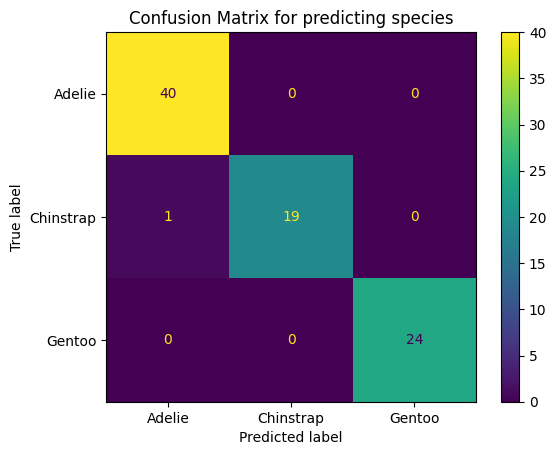

In [14]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(
    penguins_df, target, test_size=0.25, random_state=42
)

# classifier = LogisticRegressionCV(max_iter=10000)
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(max_iter=10000)
)
pipe.fit(X_train, y_train)

print(f"Classes: {pipe.classes_}")
print(f"Best C: {pipe.named_steps['logisticregressioncv'].C_}")

y_pred = pipe.predict(X_test)
inverse_dict = {v: k for k, v in dict(discrete_values[target_name]).items()}

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=[inverse_dict[i] for i in pipe.classes_]
)
disp.ax_.set_title(f"Confusion Matrix for predicting {target_name}")
plt.show()

Binary classification is tricky. Let's say we're screening for a rare disease. Only 1 out of every 10000 people has the disease or 0.01% of the population. We train our model with logistic regression to always predict 0 (no disease). And... it won't go well. This model would be 99.99% accurate, even though it's not doing anything.

In real-world use cases, classification problems are much more common than regression problems. A false positive may be more costly than a false negative or vice versa. In the criminal justice system, a defendant is convicted only if the evidence points to guilt "beyond a reasonable doubt". This is very different from "more likely than not". Although the law doesn't specify an exact probability, most people would interpret "beyond a reasonable doubt" as something like a 99% chance of guilt or even higher.

We decide that it's better to err on the side of letting a guilty person go free than locking up an innocent person. A false positive is more costly than a false negative. We need strong evidence to put someone away and the burden of proof is on the prosecution.

We take a cancer screening. Would you rather experience a false positive (the test says you have cancer when you don't) or a false negative (the test says you're healthy when you have cancer)? While a false positive may give you a scare until you undergo testing, a false negative can literally kill you.

We find our accuracies with two general metrics:
- Area Under the Curve of the Receiver Operating Characteristic graph (AUC ROC)
- Matthews Correlation Coefficient (MCC).

### AUC ROC

AUC ROC is a graph with the true positive rate on the vertical axis and the false positive rate on the horizontal axis. We adjust the probability threshold and draw a curve to adjust from 0 to 1, resulting in a graph like this:

![AUC ROC](../assets/auc-roc.png)

Calculate the area under the curve. An area of 1 indicates a perfect model. We'll never see this in practice. An area of 0.5 is useless, think about flipping a coin. In theory, we get an area as low as 0, although if our model is performing worse than a coin flip, you could simply invert its predictions to get a score above 0.5 (but if we're actually getting below 0.5, it's likely we made a mistake).

#### sklearn.metrics

- [auc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)
- [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

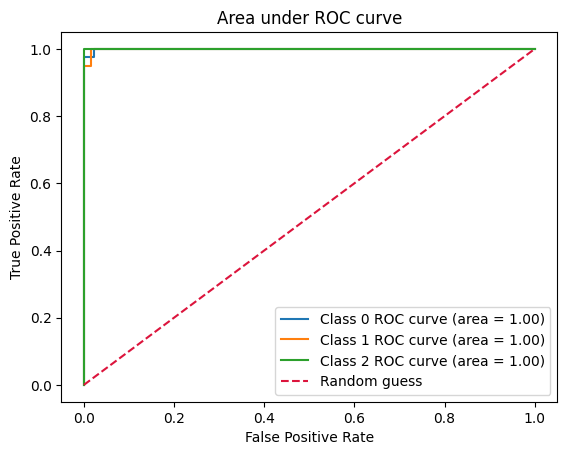

In [15]:
from sklearn.metrics import roc_curve, auc

for i in range(pipe.classes_.shape[0]):
    y_pred_prob = pipe.predict_proba(X_test)[:, i]
    # fpr = false positive rate
    # tpr = true positive rate
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {i} ROC curve (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], label="Random guess", color="crimson", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area under ROC curve")
plt.legend()
plt.show()

### Matthews Correlation Coefficient

The MCC is a general-purpose metric for binary classification because it considers all four quadrants of the confusion matrix equally. While we may not want this. If we don't have more specific information about the business need behind your model, the MCC is a great starting point. The MCC ranges from 1 for a perfect model to -1 for a perfectly wrong model.

As with the AUC ROC, if our model is performing worse than flipping coins, we should check for mistakes.

Most machine learning tools can calculate the MCC, but here is its formula.

![MCC formula](../assets/mcc.png)

#### sklearn.metrics

- [matthews_corrcoef](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)

In [16]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews correlation coefficient: {mcc}")

Matthews correlation coefficient: 0.9813968447818591
